In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2


In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'e3c11603b207c8253d21825eae59c7bc'
os.environ["KAGGLE_USERNAME"] = 'gauravmanish834'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [3]:
def compute_hog(img):
  #resizing image
  resized_img = resize(img, (128*4, 64*4))
  #creating hog features
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd


In [4]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [],[]
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                hog_feature = hog_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(hog_feature)
                y.append(folder_name)

In [5]:
X=np.array(X)
y=np.array(y)

In [6]:
y.shape

(1288,)

In [7]:
X

array([[0.04512098, 0.01909074, 0.02211192, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00501259, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.37972383, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [8]:
X.shape

(1288, 70308)

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the data
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [10]:
print(lda.coef_.shape)

(7, 70308)


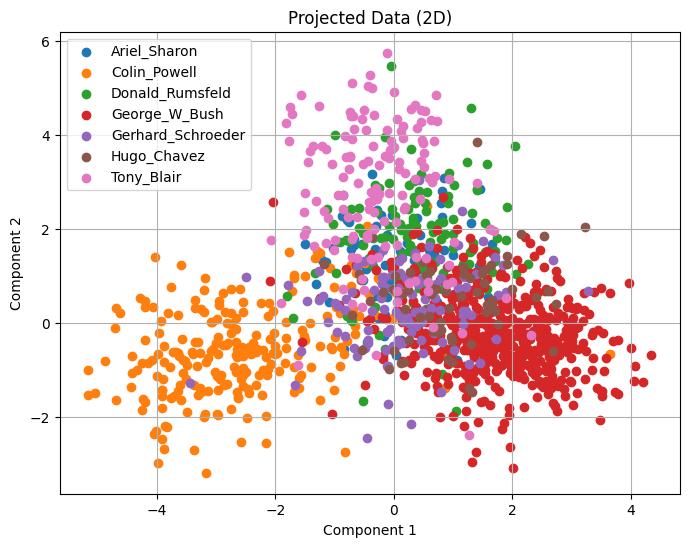

In [11]:
# Get the sorted eigenvalues and eigenvectors
eigenvalues = lda.explained_variance_ratio_
eigenvectors = lda.scalings_

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 7 components
top_components = sorted_eigenvectors

# Project the data onto the top 7 components
X_projected = np.dot(X, top_components)

# Plot the projected data
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X_projected[y == label, 0], X_projected[y == label, 1], label=label)
plt.title('Projected Data (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
X_projected.shape  #so here the dimensionality reduced to 6 (n_classes-1, and in our data the number of classes are 7)

(1288, 6)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.3, random_state=42)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()


In [15]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31,4))
weights=["uniform", "distance"]
param_grid = dict(n_neighbors=k_range ,weights=weights)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [16]:
y_pred=grid.predict(X_test)

In [17]:
nn=grid.best_params_

In [18]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['n_neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors= 9 (best case) is: 0.9095607235142119


In [19]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [20]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [21]:
# Print the best parameters and best score
print("Best parameters found: ", grid_logistic_regression.best_params_)
print("Best accuracy found: ", grid_logistic_regression.best_score_)

Best parameters found:  {'C': 0.1, 'penalty': 'l2'}
Best accuracy found:  0.8624053724053725


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size= 0.3,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=141,max_depth=61,min_samples_split=2,min_samples_leaf=5)
rf_classifier.fit(X_train,Y_train)
y_pred_rf = rf_classifier.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,y_pred_rf))

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Linear SVM
svm_linear = SVC(kernel='linear',C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print(accuracy_score(y_test,y_pred_linear))

In [ ]:
# Polynomial SVM
svm_poly = SVC(kernel='poly', degree=2,C=1)  # You can adjust the degree parameter as needed
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_poly))
print(accuracy_score(y_test,y_pred_poly))

In [ ]:
# Define parameter grids for each SVM kernel type
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'degree': [2, 3, 4],  # Polynomial degree
}

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # RBF kernel width
}

# Perform grid search for each SVM kernel type
grid_search_linear = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train, y_train)
print("Best parameters for Linear SVM:", grid_search_linear.best_params_)

grid_search_poly = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)
print("Best parameters for Polynomial SVM:", grid_search_poly.best_params_)

grid_search_rbf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train, y_train)
print("Best parameters for RBF SVM:", grid_search_rbf.best_params_)

In [ ]:
print("Accuracy for the best parameters for linear svm", accuracy_score(y_test,grid_search_linear.predict(X_test)))
print("Accuracy for the best parameters for polynomial svm", accuracy_score(y_test,grid_search_poly.predict(X_test)))
print("Accuracy for the best parameters for rbf svm", accuracy_score(y_test,grid_search_rbf.predict(X_test)))

In [ ]:




# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'n_estimators': range(1,200,10),
#     'max_depth': range(1,100,10),
#     'min_samples_split': [2],
#     'min_samples_leaf': range(1,50,10)
# }

# # Create Random Forest Classifier
# rf_classifier = RandomForestClassifier()

# # Perform grid search
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, Y_train)

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)





Best Parameters: {'max_depth': 61, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 141}
Best Score: 0.8845794966236955